## Copyright 2022 Google LLC. Double-click for license information.

In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Installation

In [2]:
%%capture
!pip3 install diffusers #==0.16.1
!pip3 install transformers  #==4.27.4
!pip3 install ftfy
!pip3 install opencv-python
!pip3 install ipywidgets
!pip3 install accelerate  #==0.18.0
!pip3 install  spacy

## Utils

In [3]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import cv2
from typing import Optional, Union, Tuple, List, Callable, Dict
from IPython.display import display
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt


def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img


def view_images(images, num_rows=1, offset_ratio=0.02):
    print(images.shape)
    print(len(images))
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    display(pil_img)


def diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False):
    if low_resource:
        noise_pred_uncond = model.unet(latents, t, encoder_hidden_states=context[0].cuda().half())["sample"]
        noise_prediction_text = model.unet(latents, t, encoder_hidden_states=context[1])["sample"]
    else:
        latents_input = torch.cat([latents] * 2).cuda().half()
        noise_pred = model.unet(latents_input, t, encoder_hidden_states=context.cuda().half())["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    latents = model.scheduler.step(noise_pred, t, latents)["prev_sample"]
    latents = controller.step_callback(latents)
    return latents


def latent2image(vae, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents)['sample']
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image


def init_latent(latent, model, height, width, generator, batch_size):
    if latent is None:
        latent = torch.randn(
            (1, model.unet.config.in_channels, height // 8, width // 8),
            generator=generator,
        )
    latents = latent.expand(batch_size,  model.unet.config.in_channels, height // 8, width // 8).to(model.device).half()
    return latent, latents


@torch.no_grad()
def text2image_ldm(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
):
    register_attention_control(model, controller)
    height = width = 256
    batch_size = len(prompt)

    uncond_input = model.tokenizer([""] * batch_size, padding="max_length", max_length=77, return_tensors="pt")
    uncond_embeddings = model.text_encoder(uncond_input.input_ids.to(model.device))[0].half()

    text_input = model.tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt")
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0].half()
    latent, latents = init_latent(latent, model, height, width, generator, batch_size)
    context = torch.cat([uncond_embeddings, text_embeddings])

    model.scheduler.set_timesteps(num_inference_steps)
    for t in tqdm(model.scheduler.timesteps):
        latents = diffusion_step(model, controller, latents, context, t, guidance_scale)

    image = latent2image(model.vqvae, latents)

    return image, latent


@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt: List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    low_resource: bool = False,
):
    register_attention_control(model, controller)
    height = width = 512
    batch_size = len(prompt)

    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0].half()
    max_length = text_input.input_ids.shape[-1]
    uncond_input = model.tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    uncond_embeddings = model.text_encoder(uncond_input.input_ids.to(model.device))[0].half()

    context = [uncond_embeddings, text_embeddings]
    if not low_resource:
        context = torch.cat(context)
    latent, latents = init_latent(latent, model, height, width, generator, batch_size)

    # set timesteps
    model.scheduler.set_timesteps(num_inference_steps)
    for t in tqdm(model.scheduler.timesteps):
        latents = diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource)

    image = latent2image(model.vae, latents)

    return image, latent


def register_attention_control(model, controller):
    def ca_forward(self, place_in_unet):
        to_out = self.to_out
        if type(to_out) is torch.nn.modules.container.ModuleList:
            to_out = self.to_out[0]
        else:
            to_out = self.to_out

        def forward(x, encoder_hidden_states=None, attention_mask=None):
            batch_size, sequence_length, dim = x.shape
            h = self.heads
            q = self.to_q(x)
            is_cross = encoder_hidden_states is not None
            encoder_hidden_states = encoder_hidden_states if is_cross else x
            k = self.to_k(encoder_hidden_states)
            v = self.to_v(encoder_hidden_states)
            q = self.head_to_batch_dim(q)
            k = self.head_to_batch_dim(k)
            v = self.head_to_batch_dim(v)

            sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale

            if attention_mask is not None:
                attention_mask = attention_mask.reshape(batch_size, -1)
                max_neg_value = -torch.finfo(sim.dtype).max
                attention_mask = attention_mask[:, None, :].repeat(h, 1, 1)
                sim.masked_fill_(~attention_mask, max_neg_value)

            # attention, what we cannot get enough of
            attn = sim.softmax(dim=-1)
            attn = controller(attn, is_cross, place_in_unet)
            out = torch.einsum("b i j, b j d -> b i d", attn, v)
            out = self.batch_to_head_dim (out)
            return to_out(out)

        return forward

    class DummyController:

        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == 'Attention':
            net_.forward = ca_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    cross_att_count = 0
    sub_nets = model.unet.named_children()
    for net in sub_nets:
        if "down" in net[0]:
            cross_att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            cross_att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            cross_att_count += register_recr(net[1], 0, "mid")

    controller.num_att_layers = cross_att_count

def show_image(images):
  num_imgs = images.shape[0]
  if num_imgs == 1:
    plt.imshow(images[0])
    plt.show()
    return

  cols = 8
  rows = num_imgs//cols
  if rows*cols != num_imgs:
    rows += 1

  plt.rcParams['figure.figsize'] = (22,8)
  fig, axes = plt.subplots(nrows=rows, ncols = cols, squeeze=False)

  for ax_ in axes.flatten():
    ax_.set_xticks([])
    ax_.set_yticks([])

  for i in range(rows):
    for j in range(cols):
      axes[i, j].set_axis_off()

  cnt = 1
  for i in range(rows):
    for j in range(cols):
      if cnt >= num_imgs:
        break
      else:
        axes[i, j].set_axis_on()
        axes[i,j].imshow(images[cnt-1])
        cnt = cnt + 1

  plt.tight_layout()
  plt.show()

## Prompt-to-Prompt with Stable Diffusion

In [4]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import StableDiffusionPipeline
import torch.nn.functional as nnf
import numpy as np
import abc

For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update ```MY_TOKEN``` with your token.
Set ```LOW_RESOURCE``` to ```True``` for running on 12GB GPU.

In [5]:
LOW_RESOURCE = True
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77

model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker = None)
pipe = pipe.to(device)
pipe.enable_attention_slicing()

tokenizer = pipe.tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


## Prompt-to-Prompt Attnetion Controllers
Our main logic is implemented in the `forward` call in an `AttentionControl` object.
The forward is called in each attention layer of the diffusion model and it can modify the input attnetion weights `attn`.

`is_cross`, `place_in_unet in ("down", "mid", "up")`, `AttentionControl.cur_step` help us track the exact attention layer and timestamp during the diffusion iference.


In [6]:
class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):

    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

In [7]:
from PIL import Image

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    #view_images(np.stack(images, axis=0))
    show_image(np.stack(images,axis=0))


def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    view_images(np.concatenate(images, axis=1))

In [8]:
def run_and_display(prompts, controller, latent=None, generator=None):
    images, x_t = text2image_ldm_stable(pipe, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    #view_images(images)
    show_image(images)
    return images, x_t

## Cross-Attention Visualization
First let's generate an image and visualize the cross-attention maps for each word in the prompt.
Notice, we normalize each map to 0-1.

  0%|          | 0/51 [00:00<?, ?it/s]

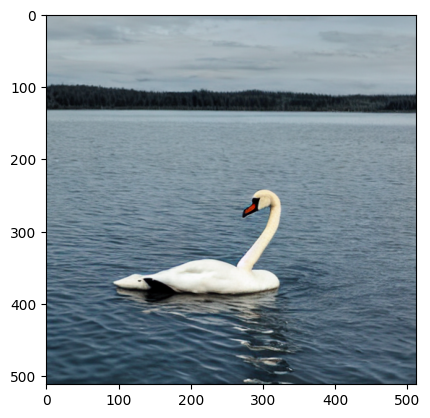

Before Attack


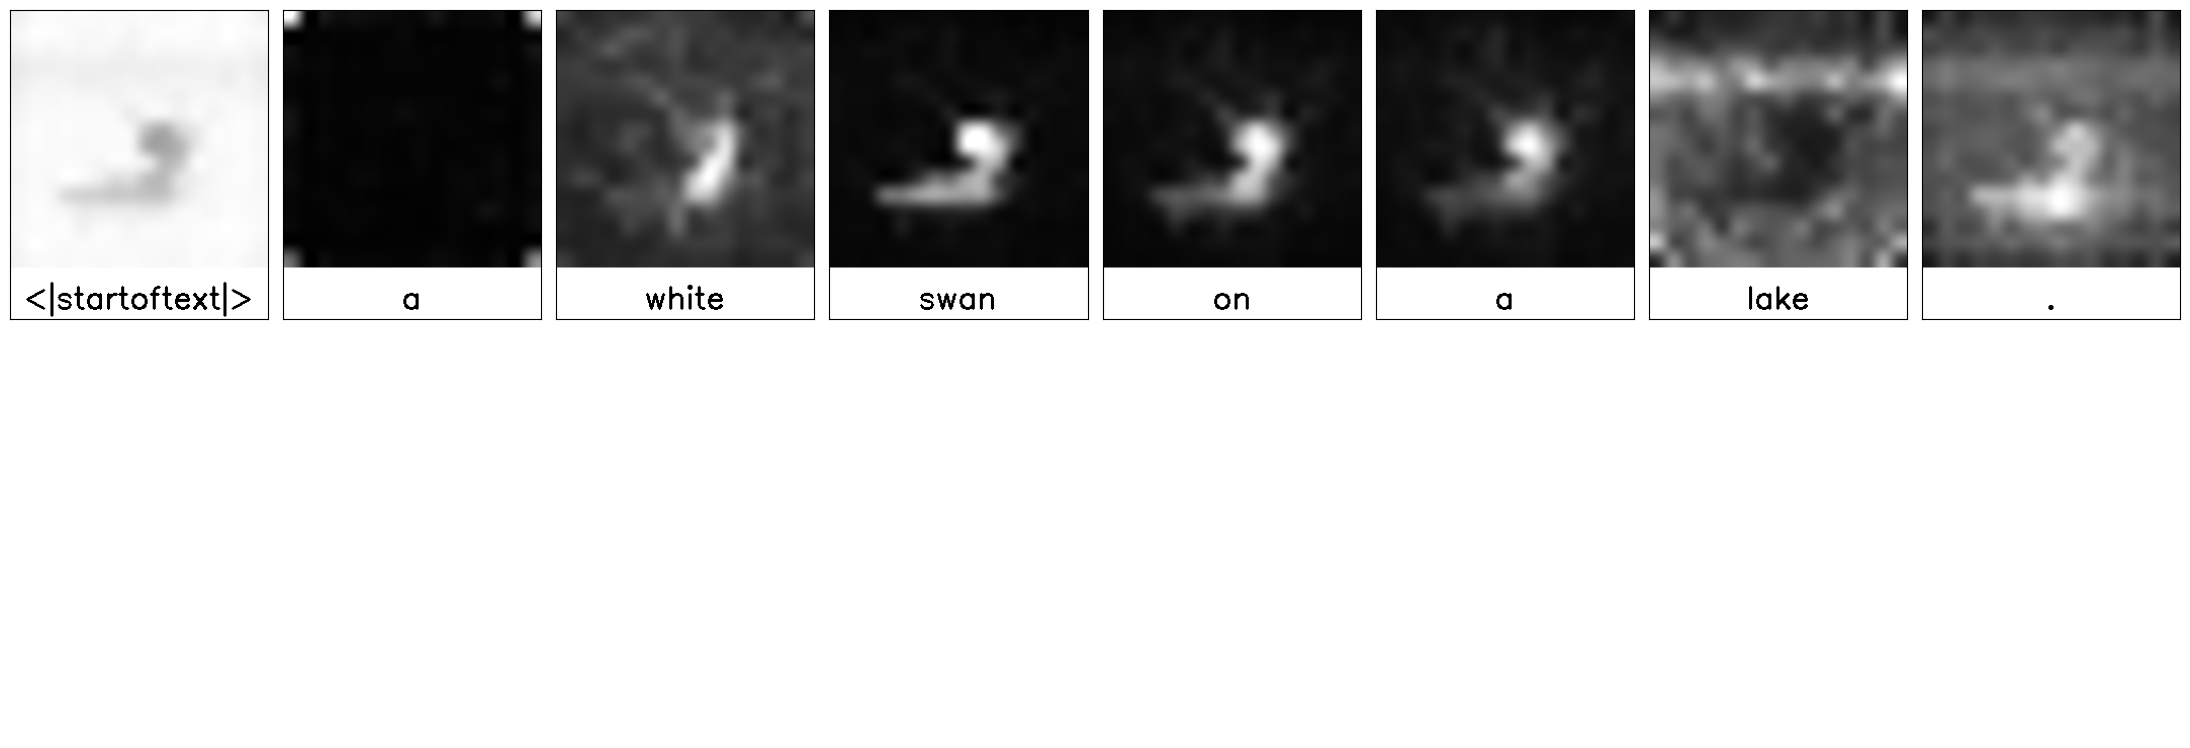

In [10]:
g_cpu = torch.Generator().manual_seed(216)
prompts = ["a white swan on a lake."]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, generator=g_cpu)

print("Before Attack")
show_cross_attention(controller, res=16, from_where=("up","down"))

  0%|          | 0/51 [00:00<?, ?it/s]

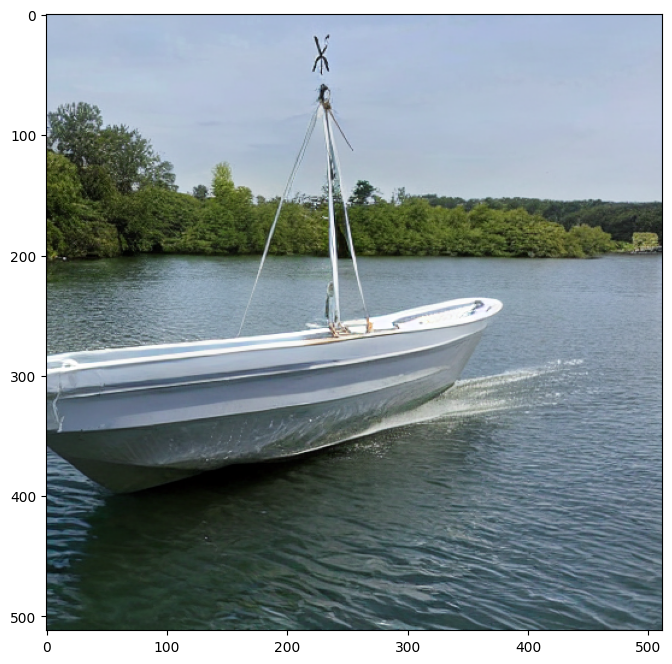

After Attack


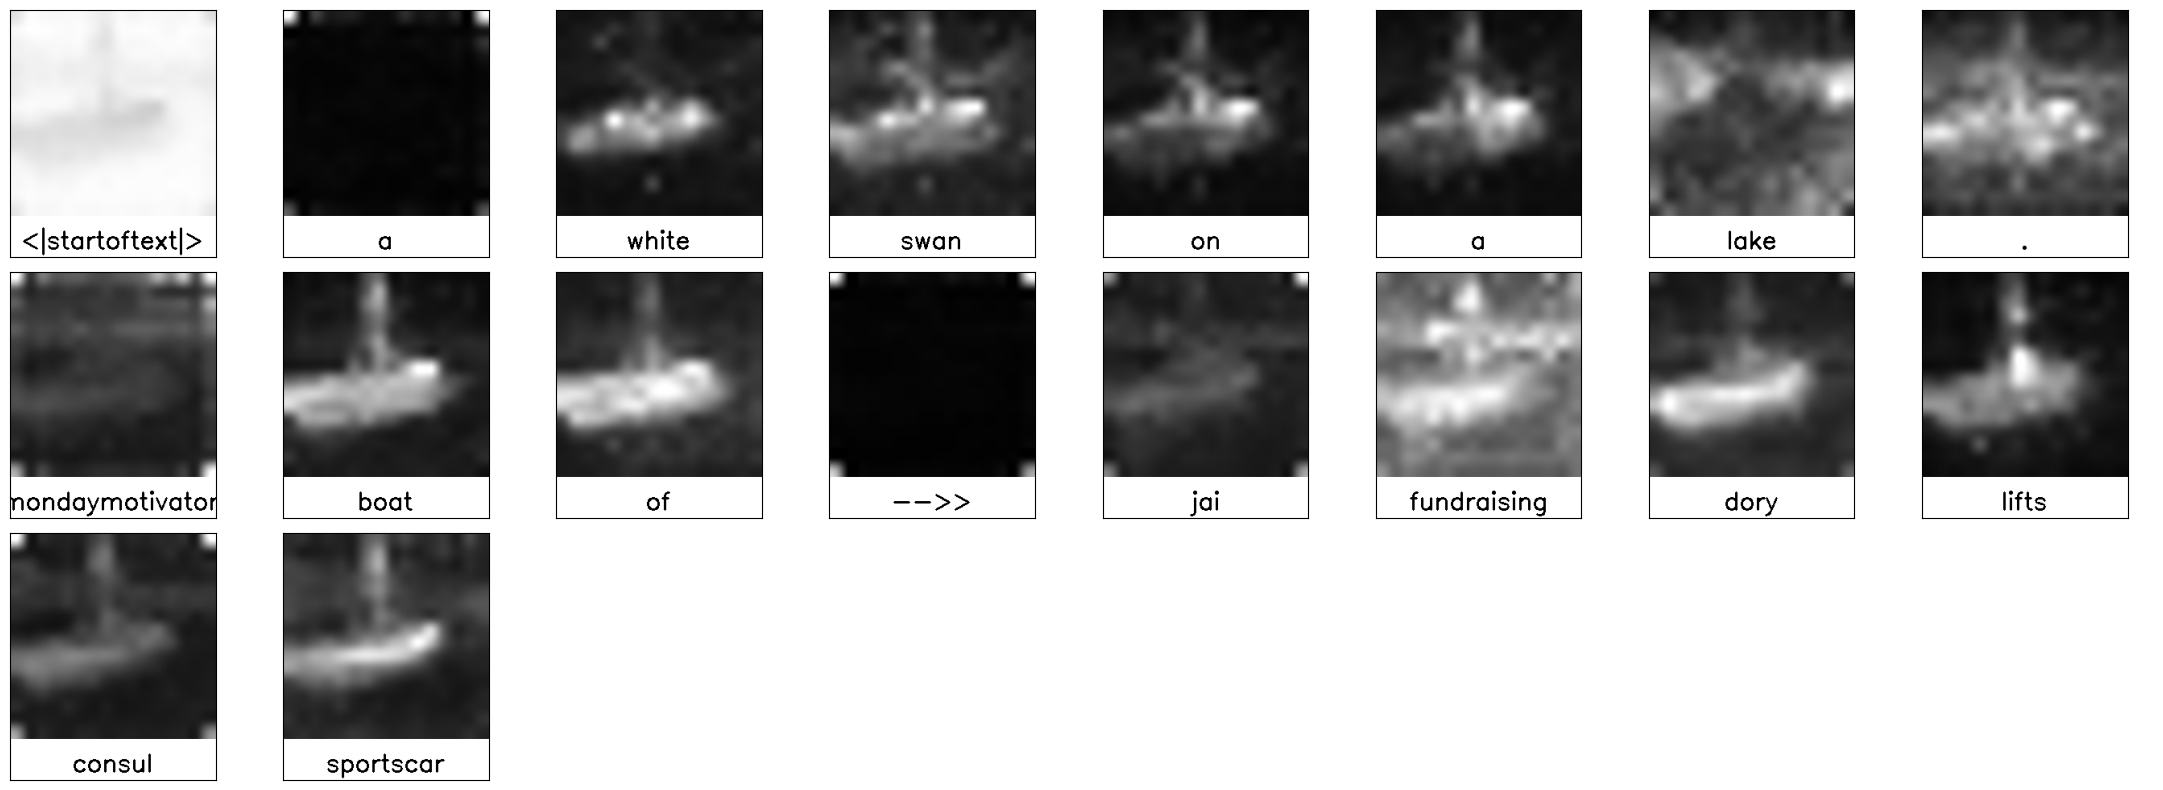

In [11]:
g_cpu = torch.Generator().manual_seed(216)
prompts = ["a white swan on a lake. mondaymotivaton boat of -->> jaifundraising dory lifts consul sportscar"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, generator=g_cpu)

print("After Attack")
show_cross_attention(controller, res=16, from_where=("up","down"))